In [1]:
import delfi.distribution as dd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from delfi.generator import Default
from delfi.simulator import Gauss
from delfi.summarystats import Identity
from helpers import *
from torch.autograd import Variable

%matplotlib inline

In [2]:
N = 20      # size of toy data

m = Gauss(noise_cov=np.sqrt(0.01))
p = dd.Uniform(lower=-2, upper=2)
s = Identity()
g = Default(model=m, prior=p, summary=s)

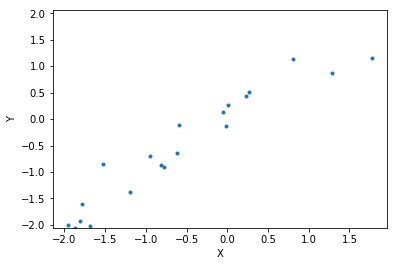

In [3]:
X, Y = g.gen(N, verbose=False);

X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');
ylim = max(abs(Y))
plt.ylim(-ylim, ylim);

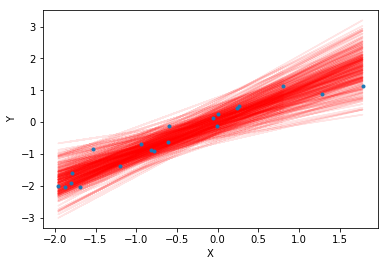

In [4]:
# posterior with bayesian linear regression

alpha = 0.01  # precision of isotropic Gaussian prior on weight
betam = 1.    # precision of model noise

m0 = 0.
S0 = 1/alpha*np.eye(2)
Phi = np.array([X.squeeze(), 
                np.ones((len(X)))]).T

SN = np.linalg.inv(alpha+betam*np.dot(Phi.T, Phi))
mN = betam*np.dot(SN, np.dot(Phi.T, Y))

for r in range(250):
    sampam = np.random.multivariate_normal(mN.squeeze(), SN, 1)
    plt.plot(X, np.dot(sampam.squeeze(), np.array([X, 1])), '-r', alpha=0.1)
plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');

In [5]:
model = MDN(svi=True, n_samples=100)

tic = time.time()
train(X, Y, model)
print('time elapsed : {:.2f}s'.format(time.time()-tic))

[epoch 0050] loss: 5.5860
[epoch 0100] loss: 4.8311
[epoch 0150] loss: 4.0454
[epoch 0200] loss: 3.5166
[epoch 0250] loss: 3.2742
[epoch 0300] loss: 2.8434
[epoch 0350] loss: 2.6581
[epoch 0400] loss: 2.6567
[epoch 0450] loss: 2.4508
[epoch 0500] loss: 2.7224
time elapsed : 13.77s


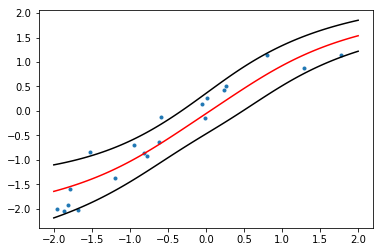

In [6]:
X_lin = np.linspace(-2, 2, 100).reshape(-1,1)
X_var_lin = Variable(torch.Tensor(X_lin))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var_lin, sample=False)

plt.plot(X, Y, '.')
plt.plot(X_lin, out_mu.data.numpy(), '-r');
plt.plot(X_lin, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X_lin, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');

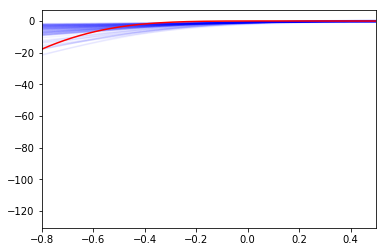

argmax C(θ)=0.082 with β=0.9


In [11]:
thetas = np.linspace(-1, 2, 500)

Cs = []
Lps = []

beta = 0.9  # beta in [0,1]. 1=mean, 0=var
prior_mean = 0.
prior_var = 0.
obs = np.array([0.5])

for theta in thetas:   
    x_param = Variable(torch.Tensor(np.array([theta]).astype(np.float32)))
    y_var = Variable(torch.Tensor(obs))
    C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
    
    C = C.data.numpy()
    Lp = Lp.data.numpy()
    
    Cs.append(C)
    Lps.append(Lp)
    
plt.plot(thetas, Lps, '-b', alpha=0.05);
plt.plot(thetas, Cs, '-r');
#plt.axis('off');
plt.xlim([-0.8, 0.5])
plt.show();

print('argmax C(θ)={:.3f} with β={}'.format(thetas[np.nanargmax(Cs)], beta))
if np.any(np.isnan(Cs)):
    print('Warning: Cs contain NaNs')

In [12]:
tic = time.time()

t_init = np.array([0.0]).astype(np.float32)
x_param = nn.Parameter(torch.from_numpy(t_init))

optim = torch.optim.Adam([x_param], lr=0.1)

for i in range(100):
    optim.zero_grad()
    C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
    C = -1*C
    C.backward()
    optim.step()

t_star = x_param.data.numpy()[0]

print('time elapsed : {:.2f}s'.format(time.time()-tic))
print('θ* = {:.2f}'.format(t_star))

time elapsed : 1.01s
θ* = 0.08


In [ ]:
for i in range(25):
    t_init = np.array([0.0]).astype(np.float32)
    x_param = nn.Parameter(torch.from_numpy(t_init))
    optim = torch.optim.Adam([x_param], lr=0.1)
    for i in range(100):
        optim.zero_grad()
        C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
        C = -1*C
        C.backward()
        optim.step()
    t_star = x_param.data.numpy()[0]
    print('new θ* = {:.2f}'.format(t_star))

    idx = np.arange(0, len(X), 1)
    np.random.shuffle(idx)

    N_REPS = 5
    X_retrain = np.repeat(np.array([[t_star]]), N_REPS, axis=0)
    Y_retrain = s.calc(m.gen([t_star], verbose=False, n_reps=N_REPS)[0])

    X_retrain = np.concatenate((X_retrain, X))
    Y_retrain = np.concatenate((Y_retrain, Y))
    X = X_retrain
    Y = Y_retrain

    #M = N
    #X_retrain = np.concatenate((X_retrain, X[idx[:M], :]))
    #Y_retrain = np.concatenate((Y_retrain, Y[idx[:M], :]))

    tic = time.time()
    train(X_retrain, Y_retrain, model)
    print('time elapsed : {:.2f}s'.format(time.time()-tic))

new θ* = 0.08
[epoch 0050] loss: 2.0895
[epoch 0100] loss: 2.3886
[epoch 0150] loss: 2.0946
[epoch 0200] loss: 2.2969


In [ ]:
X_lin = np.linspace(-2, 2, 100).reshape(-1,1)
X_var_lin = Variable(torch.Tensor(X_lin))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var_lin, sample=False)

plt.plot(X, Y, '.')
plt.plot(X_lin, out_mu.data.numpy(), '-r');
plt.plot(X_lin, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X_lin, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');